In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [51]:
df = pd.read_csv('processed_player_stats.csv')
df = df.dropna()
sc = StandardScaler()

df.columns


Index(['role', 'rounds_played', 'rating', 'avg_combat_score', 'kd_ratio',
       'kast_percent', 'avg_damage_per_round', 'kills_per_round',
       'assists_per_round', 'first_kills_per_round', 'first_deaths_per_round',
       'headshot_percent', 'kills', 'deaths', 'assists', 'first_kills',
       'first_deaths'],
      dtype='object')

In [52]:
def split_data(df: pd.DataFrame):
    X = df.drop('role', axis=1).values
    y = df['role'].values

    global X_train, X_test, y_train, y_test 
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    X_test = sc.fit_transform(X_test)
    X_train = sc.fit_transform(X_train) 
    return X_train, X_test, y_train, y_test

### Random Forest

              precision    recall  f1-score   support

           0       0.57      0.58      0.58       373
           1       0.49      0.44      0.46       222
           2       0.49      0.45      0.47       347
           3       0.69      0.81      0.74       259

    accuracy                           0.57      1201
   macro avg       0.56      0.57      0.56      1201
weighted avg       0.56      0.57      0.56      1201



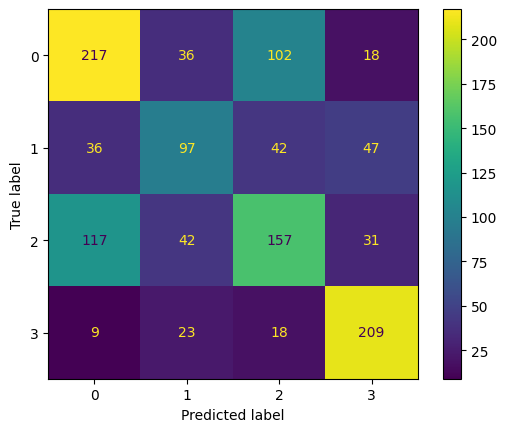

In [53]:
# Define the selected features based on the actual column names
selected_features = ['avg_damage_per_round', 
                     'kills_per_round', 'assists_per_round', 'first_kills_per_round', 
                     'first_deaths_per_round', 'rating']

def select_features(df: pd.DataFrame, selected_features: list) -> pd.DataFrame:
    """
    Subsets the DataFrame to keep only the selected features.
    """
    return df[selected_features+ ['role']]

def random_forest(df: pd.DataFrame, selected_features: list):
    """
    trains a random forest classifier using selected features
    """
    df_selected = select_features(df, selected_features)

    split_data(df_selected)
 
    rf = RandomForestClassifier(n_estimators=300, 
                                max_depth=30,
                                max_features='sqrt',
                                class_weight='balanced',
                                random_state=42)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    return ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

random_forest(df, selected_features)


### KNN

(0.5253955037468776,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x10cfa7760>)

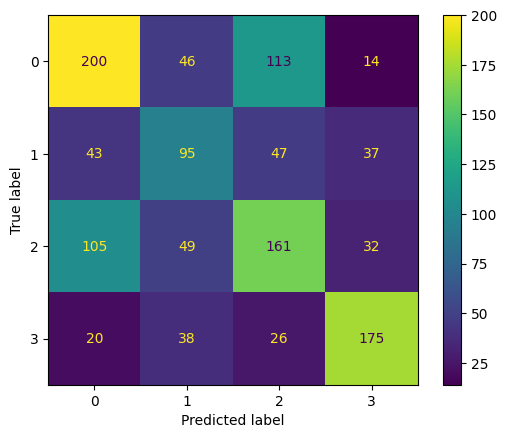

In [54]:
def opt_knn(df: pd.DataFrame, selected_features: list):   
    
    df_selected = select_features(df, selected_features)
    split_data(df_selected)
    high_score = 0
    opt_k = 0
    k=1

    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = knn.score(X_test, y_test)
    return score, ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)

opt_knn(df, selected_features) #result with standard scaler: 0.5245628642797668


In [55]:
def svm_model(data: pd.DataFrame, col: str = 'role'):
    # Split the data into features (X) and target (y)
    X = data.drop(col, axis=1)
    y = data[col]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Feature scaling (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the classifier
    classifier = SVC(kernel='linear', random_state=42)

    # Train the model
    classifier.fit(X_train_scaled, y_train)

    # Predict using the test set
    y_pred = classifier.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Example usage
accuracy = svm_model(df, 'role')
print(f"SVM Model Accuracy: {accuracy}")


SVM Model Accuracy: 0.517901748542881


All 3 models gave a similar result, with all of them only having slightly above 0.5 accuracy. Looking at the confusion matrices give more insight as to why this is; role 0 (controller) and role 4 (duelist) have the most correct classifications, and from a player perspective this makes sense as they have the most distinct play styles(duelists take space on the map, controllers control space on the map). role 1 (initiator) and role 3 (sentinel) have less rigid play styles and thus are harder to classify purely from the data the models are trained on (sentinels and initiators especially also have a high amount of diversity in their character abilities). 